Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Hung-Wei Chang"
COLLABORATORS = ""

---

<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

# Assignment 9: Bulldozer Bluebook
The dataset we will work with in this example includes data on over 400k historical sales of heavy machinery equipment (bulldozers, etc) at auction.  The objective is to develop a model which can predict the expected sale price of a piece of machinery given different information about the machine's condition and type, similar to what Kelly Blue Book does for used cars. 

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression, f_classif
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import seaborn as sns
from scipy.stats import pearsonr

path = Path('')

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Run this before any other code cell
# This downloads the csv data files into the same directory where you have saved this notebook

import urllib.request
from pathlib import Path
import os
path = Path()

# Dictionary of file names and download links
files = {'bulldozer_data.csv':'https://storage.googleapis.com/aipi_datasets/bulldozer_data.csv'}

# Download each file
for key,value in files.items():
    filename = path/key
    url = value
    # If the file does not already exist in the directory, download it
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url,filename)

In [4]:
# Read in the raw data
df_raw = pd.read_csv(path/'bulldozer_data.csv',)
print('Shape is {}'.format(df_raw.shape))
df_raw.head().T

Shape is (401125, 47)


,0,1,2,3,4
SalePrice,66000,57000,10000,38500,11000
ModelID,3157,77,7009,332,17311
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68,4640,2838,3486,722
UsageBand,Low,Low,High,High,Medium
fiModelDesc,521D,950FII,226,PC120-6E,S175
fiBaseModel,521,950,226,PC120,S175
fiSecondaryDesc,D,F,NaN,NaN,NaN
fiModelSeries,NaN,II,NaN,-6E,NaN
fiModelDescriptor,NaN,NaN,NaN,NaN,NaN


In [5]:
# Define categorical and continuous variables
allvars = df_raw.columns

cont_vars = ['YearMade','MachineHoursCurrentMeter'] # Continuous variables
ord_vars = ['UsageBand'] # Ordinal categorical variables
cat_vars = allvars.drop('SalePrice').drop(cont_vars).drop(ord_vars).to_list() # Other categorical variables

print(f'Continuous variables are {cont_vars} \n')
print(f'Ordinal variables are {ord_vars} \n')
print(f'Other categorical variables are {cat_vars} \n')

Continuous variables are ['YearMade', 'MachineHoursCurrentMeter'] 

Ordinal variables are ['UsageBand'] 

Other categorical variables are ['ModelID', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries', 'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls', 'Differential_Type', 'Steering_Controls'] 



## Clean up data
Let's start by cleaning up the data.  As you will see when you run the cell below, we have a lot of missing data we need to take care of before we can do any modeling.

In [6]:
# Check for null values
df_raw.isna().sum()

SalePrice                        0
ModelID                          0
YearMade                         0
MachineHoursCurrentMeter    258360
UsageBand                   331486
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             137191
fiModelSeries               344217
fiModelDescriptor           329206
ProductSize                 210775
fiProductClassDesc               0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                296764
Enclosure                      325
Forks                       209048
Pad_Type                    321991
Ride_Control                252519
Stick                       321991
Transmission                217895
Turbocharged                321991
Blade_Extension             375906
Blade_Width                 375906
Enclosure_Type              375906
Engine_Horsepower           375906
Hydraulics                   80555
Pushblock                   375906
Ripper              

### Q1 [20 points]
Complete the below function `clean_data()` which takes as input the raw data dataframe and the lists of continuous variables, ordinal variables and categorical variables.  The function should fill the null values as follows:  
- For continuous features, fill null values with the mean value of the column  
- For ordinal features, fill the null values with the most frequent value (mode). 
- For categorical features, fill the null values with a new category called "undefined"

Your function should return the input dataframe with all null values filled as above.

In [7]:
def clean_data(df,cont_vars,ord_vars,cat_vars):
    # YOUR CODE HERE
    df_clean = df.copy()
    # Fill the continuous columns using mean
    for col in cont_vars:
        df_clean.loc[:,col] = df_clean.loc[:,col].fillna(df_clean.loc[:,col].mean())
    # Fill the categorical column using the mode
    for col in ord_vars:
        df_clean.loc[:,col] = df_clean.loc[:,col].fillna(df_clean.loc[:,col].mode()[0])
    
    for col in cat_vars:
        df_clean.loc[:,col] = df_clean.loc[:,col].fillna('undefined')
    
    return df_clean
    raise NotImplementedError()

In [8]:
# Test cell for clean_data()
df_processed = df_raw.copy()
df_processed = clean_data(df_processed,cont_vars,ord_vars,cat_vars)

# Confirm we nave no more missing values
assert df_processed.isna().sum().sum()==0

for col in cont_vars:
    assert np.round(df_processed[col].mean(),1)==np.round(df_raw[col].mean(),1)

for col in ord_vars:
    assert df_processed[col].mode().values[0]==df_raw[col].mode().values[0]

for col in cat_vars:
    if df_raw[col].isna().sum()>0:
        assert 'undefined' in df_processed[col].values.tolist()

### Q2 [10 points]
We now need to create our input feature matrix X and target array y, and then split our data into training and test sets.  Complete the below function `split_data()` which takes the processed data as input and returns the split data `X_train,X_test,y_train,y_test` as dataframes.  Use `train_test_split()` to split your data and set a test size of 20% and `random_state=0` when using the method.

In [9]:
def split_data(df):
    # YOUR CODE HERE
    
    df_split = df.copy()
    # Create feature matrix X and target array y
    X = df_split.drop('SalePrice',axis=1)
    y = df_split['SalePrice']

    # Split data into training and test sets
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0) 
    return  X_train,X_test,y_train,y_test
    
    raise NotImplementedError()

In [10]:
# Test cell for split_data()
X_train,X_test,y_train,y_test = split_data(df_processed)
assert X_train.shape==(320900, 46)
assert y_train.shape==(320900,)
assert X_test.shape==(80225, 46)
assert y_test.shape==(80225,)

## Univariate feature selection
We will now perform univariate feature selection using our training set to see if we have any features which we can remove before we proceed.
### Q3 [15 points]
Let's start with our continuous features.  Complete the below function `cont_feat_selection()` which takes as input the subset of X_train which contains continuous data (`cont_data`), and y_train.  The function should perform a univariate test on the features in `cont_data` using SelectKBest.  You should use `f_regression` as the scoring function (which evaluates features based on correlation with the numerical target).  Your function should return a dataframe containing two columns:   
- `Feature` should contain the name of each continuous feature  
- `Score` should contain each feature's corresponding score on the univariate test

Your dataframe should be sorted by `Score` with the features with the largest scores first.

In [11]:
def cont_feat_selection(cont_data,y):
    # YOUR CODE HERE
    
    # Evaluate continuous features using pearson's correlation coefficient (score_func = f_regression)
    ftest = SelectKBest(score_func=f_regression, k='all')
    ftest.fit(cont_data,y)
    f_scores = pd.DataFrame(ftest.scores_)
    dfcolumns = pd.DataFrame(cont_data.columns)
    f_scores = pd.concat([dfcolumns,f_scores],axis=1)
    f_scores.columns = ['Feature','Score']  
    f_scores = f_scores.sort_values(by='Score',ascending=False)
    return f_scores
    raise NotImplementedError()

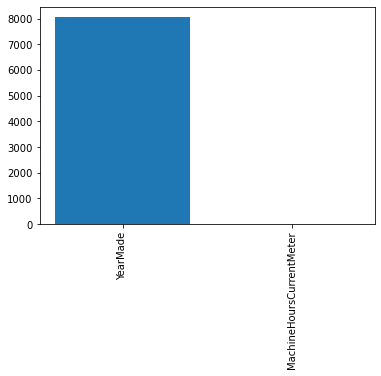

In [12]:
# Test cell for cont_feat_selection()
# Get scores of continuous features
cont_scores = cont_feat_selection(X_train[cont_vars],y_train)

assert cont_scores.shape==(2,2)
for col in ['Feature','Score']:
    assert col in cont_scores.columns
    
assert cont_scores['Score'][0]>=cont_scores['Score'][1]

# Plot scores
plt.bar(x=cont_scores['Feature'],height=cont_scores['Score'])
plt.xticks(rotation=90)
plt.show()

### Q4 [15 points]
Now let's tackle the categorical feature selection.  One slighly complicating factor is that all categorical data must be converted to numeric before we can run the univariate tests.  The cell below the function does this conversion for you.

Your job is to complete the function `cat_feature_selection()` which takes as input the categorical data from X_train and the y_train dataframe.  The function should use `SelectKBest` with an ANOVA test (`score_func=f_classif`) to get the score for each categorical feature.  Your function should return a dataframe with the following columns:  
- Feature: name of each feature. 
- Score: F-score of each feature from the ANOVA test    

Your dataframe should be sorted by `Score` with the features with the largest scores first.

In [13]:
def cat_feature_selection(cat_data,y):
    # YOUR CODE HERE
    # Evaluate categorical features using pearson's correlation coefficient (score_func = f_regression)
    ftest = SelectKBest(score_func=f_regression, k='all')
    ftest.fit(cat_data,y)
    f_scores = pd.DataFrame(ftest.scores_)
    dfcolumns = pd.DataFrame(cat_data.columns)
    f_scores = pd.concat([dfcolumns,f_scores],axis=1)
    f_scores.columns = ['Feature','Score']  
    f_scores = f_scores.sort_values(by='Score',ascending=False)
    return f_scores
    
    raise NotImplementedError()

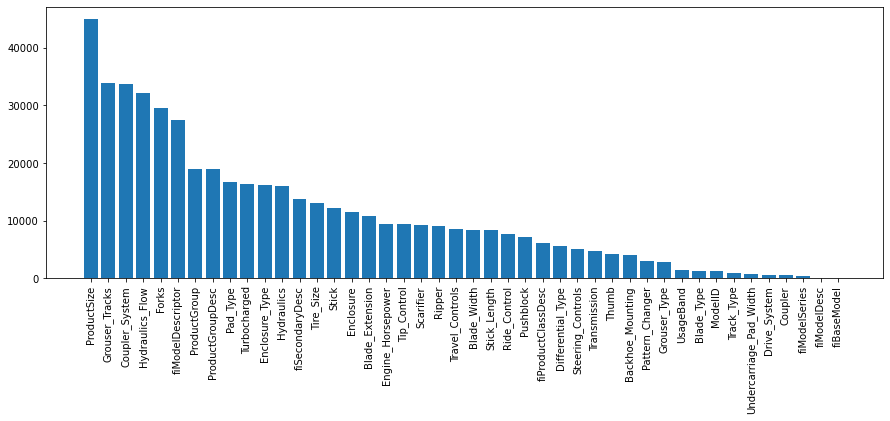

In [14]:
# Test cell for cat_feature_selection()

all_cat_vars = cat_vars + ord_vars
# Categorical features - need to convert to numerical codes prior to statistical tests
X_featselect_cat = X_train[all_cat_vars]
X_featselect_cat = X_featselect_cat.astype('category')
X_featselect_cat = X_featselect_cat.apply(lambda x: x.cat.codes,axis=0)

# Run function to get univariate scores
scores = cat_feature_selection(X_featselect_cat,y_train)

assert scores.shape==(44,2)
for col in ['Feature','Score']:
    assert col in scores.columns
    
assert scores['Score'][0]>=scores['Score'][1]

# Plot scores
plt.figure(figsize=(15,5))
plt.bar(x=scores['Feature'],height=scores['Score'])
plt.xticks(rotation=90)
plt.show()

### Q5 [10 points]
Based on our univariate feature selection, supposed we decide to drop `MachineHoursCurrentMeter`,`UsageBand`,`fiModelDesc`, and `fiBaseModel`.  Complete the below function `drop_feats()` which takes as inputs the `X_train` and `X_test` datasets and a list of features to drop.  The function should return the revised `X_train` and `X_test` with the features in `feats_to_drop` removed from both dataframes.

In [15]:
def drop_feats(X_train,X_test,feats_to_drop):
    # YOUR CODE HERE
    
    X_train_final = X_train.copy().drop(feats_to_drop, axis = 1)
    X_test_final = X_test.copy().drop(feats_to_drop, axis = 1)
    return X_train_final, X_test_final 
    raise NotImplementedError()

In [16]:
# Test cell for drop_feats()
feats_to_drop = ['MachineHoursCurrentMeter','UsageBand','fiModelDesc','fiBaseModel']
X_train,X_test = drop_feats(X_train,X_test,feats_to_drop)

assert X_train.shape==(320900, 42)
assert X_test.shape==(80225, 42)

cont_vars = [var for var in cont_vars if var not in feats_to_drop]
ord_vars = [var for var in ord_vars if var not in feats_to_drop]
cat_vars = [var for var in cat_vars if var not in feats_to_drop]

## Encode categorical variables
### Q6 [20 points]
We will now encode our categorical variables in preparation for passing them into a model.  Complete the below function `encode_variables()`.  The function takes the `X_train` dataframe as input and two lists: `ord_cols` contains the names of the columns which we will ordinal encode, and `onehot_cols` contains the names of the columns which we will one-hot encode.  Your function should perform the ordinal and onehot encoding on the correct features and then return the training data dataframe with the categorical features encoded (your continuous features should also be included).  Note: after applying the onehot encoding make sure to remove the original columns.

When performing ordinal encoding, use the following arguments to handle the case where it encounters a category that is not found in the training data: `handle_unknown='use_encoded_value', unknown_value=-1`.  When performing one-hot encoding, use the following to handle this case:  `handle_unknown='ignore'`.

Note: we could onehot encode all our non-ordinal columns, but it can take a long time and produce a very large number of columns.  Instead, we will ordinal encode any features with >20 different categories, and onehot encode only the features with <= 20 categories.  This is done for you in the test cell below to create the `ord_cols` and `onehot_cols` lists.

In [17]:
def encode_training_set(X,ord_cols,onehot_cols):
    # YOUR CODE HERE
    ## Ordinal encoder
    enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    # Fit the encoder on training data and transform it.  We can also use it to transform test data
    X[ord_cols] = enc.fit_transform(X[ord_cols])
    
    ## Onehot encoder 
    # Treat new categories as a new 'unknown' category (all onehot columns are 0)
    onehot_enc = OneHotEncoder(handle_unknown='ignore')
    # Fit encoder on training data
    onehot_enc.fit(X[onehot_cols])
    # Get the names of the new columns created
    colnames = columns=list(onehot_enc.get_feature_names(input_features=onehot_cols))
    # Transform the data
    onehot_vals = onehot_enc.transform(X[onehot_cols]).toarray()
    # Put transformed data into dataframe
    enc_df = pd.DataFrame(onehot_vals,columns=colnames,index=X.index)
    # Add onehot columns back onto original dataframe and drop the original columns
    X = pd.concat([X,enc_df],axis=1).drop(onehot_cols,axis=1)
    # X_train_encoded,ord_enc,onehot_enc
    return X, enc, onehot_enc
    
    
    raise NotImplementedError()

In [18]:
# Test cell for encode_training_set() (this may take a minute to run)
X_train_encoded = X_train.copy()

# Make sure all categorical columns are string type
for col in cat_vars:
    X_train_encoded[col] = X_train_encoded[col].astype(str)

# Onehot encode all features with >20 categories, and ordinal encode the rest
onehot_vars = []
for var in cat_vars:
    if X_train_encoded[var].nunique()>20:
        ord_vars.append(var)
    else:
        onehot_vars.append(var)
print('Features to ordinal encode: {}\n'.format(ord_vars))
print('Features to one-hot encode: {}'.format(onehot_vars))

X_train_encoded,ord_enc,onehot_enc = encode_training_set(X_train_encoded,ord_vars,onehot_vars)
print('Encoding done')

for col in cont_vars:
    assert col in X_train_encoded.columns
    
for col in ord_vars:
    assert col in X_train_encoded.columns
    
for col in onehot_vars:
    assert col not in X_train_encoded.columns
    
assert X_train_encoded.shape == (320900, 210)

Features to ordinal encode: ['ModelID', 'fiSecondaryDesc', 'fiModelSeries', 'fiModelDescriptor', 'fiProductClassDesc', 'Stick_Length']

Features to one-hot encode: ['ProductSize', 'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type', 'Undercarriage_Pad_Width', 'Thumb', 'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls', 'Differential_Type', 'Steering_Controls']
Encoding done


### Q7 [10 points]
Now let's use our encoders to encode the test set.  Complete the below function `encode_test_set()` which takes as input the test set data, the list of features to encode as ordinal (`ord_cols`), the list of features to encode as one-hot (`onehot_cols`), the ordinal encoder fit on the training set (`ord_enc`) and the onehot encoder fit on the training set (`onehot_enc`).  The function should use the appropriate encoders to do the ordinal and onehot encoding on the test set data.  It should then return the test set dataframe with the categorical data encoded (the continuous columns should be included as they are).

In [19]:
def encode_test_set(X,ord_cols,onehot_cols,ord_enc,onehot_enc):
    # YOUR CODE HERE
    
    # Apply ordinal encoder
    X[ord_cols] = ord_enc.transform(X[ord_cols])
    
    # Apply onehot encoder
    colnames = columns=list(onehot_enc.get_feature_names(input_features=onehot_cols))
    onehot_vals = onehot_enc.transform(X[onehot_cols]).toarray()
    # Put transformed data into dataframe
    enc_df = pd.DataFrame(onehot_vals,columns=colnames,index=X.index)
    # Add onehot columns back onto original dataframe and drop the original columns
    X = pd.concat([X,enc_df],axis=1).drop(onehot_cols,axis=1)
    return X
    
    raise NotImplementedError()

In [20]:
# Test cell for encode_test_set()
X_test_encoded = X_test.copy()

# Make sure all categorical columns are string type
for col in cat_vars:
    X_test_encoded[col] = X_test_encoded[col].astype(str)

X_test_encoded = encode_test_set(X_test_encoded,ord_vars,onehot_vars,ord_enc,onehot_enc)
print('Encoding done')

for col in cont_vars:
    assert col in X_test_encoded.columns
    
for col in ord_vars:
    assert col in X_test_encoded.columns
    
for col in onehot_vars:
    assert col not in X_test_encoded.columns

assert X_test_encoded.shape == (80225, 210)

Encoding done


## Model
Now that both our training and test sets are encoded into numerical values, we can feed them both into a model.

In [21]:
model = LinearRegression()
model.fit(X_train_encoded,y_train)
testpreds = model.predict(X_test_encoded)
r2 = r2_score(y_test,testpreds)
print("The model's R-squared value on the test set is {:.3f}".format(r2))

assert np.round(r2,1)==0.5

The model's R-squared value on the test set is 0.526
